In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.simulate import simulate_networks
from inv_vae.utils.helpers import Namespace, reset_weights
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

simulate noise-free and noise-affected networks

In [3]:
n_nets = 1000
n_nodes = 68
p_in = .25
p_out = .01
n_noisy_nets = int(n_nets*.2)
noise_level = .6
noise_sd = .05

In [4]:
sim_nets, noisy_nets, noises, noise_ids = simulate_networks(n_nets=n_nets, n_nodes=n_nodes, p_in=p_in, p_out=p_out, seed=seed,
                                          n_noisy_nets=n_noisy_nets, noise_level=noise_level, noise_sd=noise_sd)
print(sim_nets.shape, noisy_nets.shape, noises.shape)

(1000, 68, 68) (1000, 68, 68) (1000,)


In [5]:
big_sim_nets = sim_nets[np.arange(n_noisy_nets)]
small_sim_nets = sim_nets[np.arange(n_noisy_nets, n_nets)]
diff_sim_nets = small_sim_nets.mean(0) - big_sim_nets.mean(0)

big_noise_nets = noisy_nets[np.arange(n_noisy_nets)]
small_noise_nets = noisy_nets[np.arange(n_noisy_nets, n_nets)]
diff_noise_nets = small_noise_nets.mean(0) - big_noise_nets.mean(0)

In [6]:
# PCA projections of noise-free and noise-affected networks for visualizations

pca = PCA(2)
sim_Xt = pca.fit_transform(sim_nets.reshape(-1, n_nodes*n_nodes))
noisy_Xt = pca.fit_transform(noisy_nets.reshape(-1, n_nodes*n_nodes))
sim_df = pd.DataFrame({"pc1": sim_Xt[:,0], "pc2": sim_Xt[:,1], "noise": noises})
noisy_df = pd.DataFrame({"pc1": noisy_Xt[:,0], "pc2": noisy_Xt[:,1], "noise": noises})

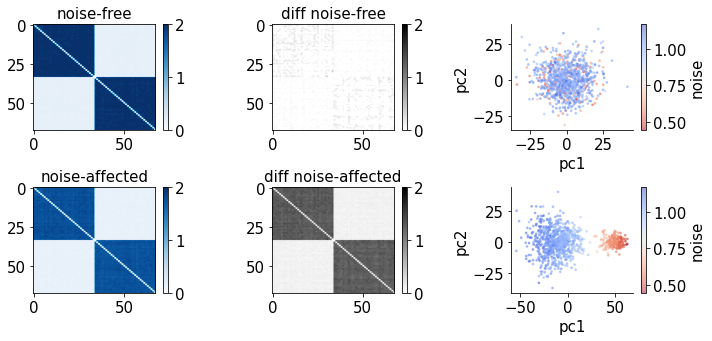

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

p1 = axes[0,0].imshow(sim_nets.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0,0].set_title('noise-free')
cbar = plt.colorbar(p1, ax=axes[0,0])

p2 = axes[0,1].imshow(diff_sim_nets, aspect='auto', cmap='binary', vmin=0, vmax=2)
axes[0,1].set_title('diff noise-free')
cbar = plt.colorbar(p2, ax=axes[0,1])

p3 = axes[0,2].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm_r', data=sim_df, s=3, alpha=0.5)
axes[0,2].set_xlabel('pc1')
axes[0,2].set_ylabel('pc2')
axes[0,2].spines['top'].set_visible(False)
axes[0,2].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[0,2], label="noise")

p4 = axes[1,0].imshow(noisy_nets.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[1,0].set_title('noise-affected')
cbar = plt.colorbar(p4, ax=axes[1,0])

p5 = axes[1,1].imshow(diff_noise_nets, aspect='auto', cmap='binary', vmin=0, vmax=2)
axes[1,1].set_title('diff noise-affected')
cbar = plt.colorbar(p5, ax=axes[1,1])

p6 = axes[1,2].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm_r', data=noisy_df, s=3, alpha=0.5)
axes[1,2].set_xlabel('pc1')
axes[1,2].set_ylabel('pc2')
axes[1,2].spines['top'].set_visible(False)
axes[1,2].spines['right'].set_visible(False)
cbar = plt.colorbar(p6, ax=axes[1,2], label="noise")

plt.tight_layout()
plt.show()

prepare torch datasets for training

In [32]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = .1, add_reg = False, y_dim = 0, 
    batch_size=32, n_epochs=200, lr=3e-6, device=DEVICE)

In [33]:
ids = list(range(n_nets))
random.shuffle(ids)
train_ids = ids[:int(.9*n_nets)]
val_ids = ids[int(.9*n_nets):]
print(len(train_ids), len(val_ids))
tensor_nets = torch.stack([torch.Tensor(i) for i in list(noisy_nets)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_noises = torch.from_numpy(noises).to(torch.float32).view(-1, 1)

train_set = utils.TensorDataset(tensor_nets[train_ids], 
                        tensor_noises[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], 
                        tensor_noises[val_ids] )

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

900 100


In [34]:
# create masks for graph convolution layers

A_mat = np.mean(noisy_nets, axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i).float().to(config.device) for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

5 torch.Size([68, 68])


vae

In [35]:
model = VAE(config).to(config.device)
model.apply(reset_weights)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [36]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.custom_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.custom_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 5366.431 nll: 5365.635 kl: 7.956
epoch: 0 test loss 4560.809 nll: 4559.760 kl: 10.490
epoch: 5 train loss: 2941.775 nll: 2940.913 kl: 8.620
epoch: 5 test loss 2867.253 nll: 2866.270 kl: 9.835
epoch: 10 train loss: 2775.104 nll: 2773.426 kl: 16.784
epoch: 10 test loss 2738.390 nll: 2736.623 kl: 17.668
epoch: 15 train loss: 2739.107 nll: 2737.507 kl: 15.997
epoch: 15 test loss 2710.188 nll: 2708.535 kl: 16.528
epoch: 20 train loss: 2727.381 nll: 2725.767 kl: 16.134
epoch: 20 test loss 2701.145 nll: 2699.451 kl: 16.940
epoch: 25 train loss: 2722.226 nll: 2720.388 kl: 18.373
epoch: 25 test loss 2697.135 nll: 2695.212 kl: 19.230
epoch: 30 train loss: 2719.228 nll: 2717.040 kl: 21.879
epoch: 30 test loss 2694.894 nll: 2692.602 kl: 22.925
epoch: 35 train loss: 2717.063 nll: 2714.373 kl: 26.906
epoch: 35 test loss 2693.836 nll: 2691.026 kl: 28.097
epoch: 40 train loss: 2715.099 nll: 2711.844 kl: 32.557
epoch: 40 test loss 2692.506 nll: 2689.110 kl: 33.963
epoch: 45 train l

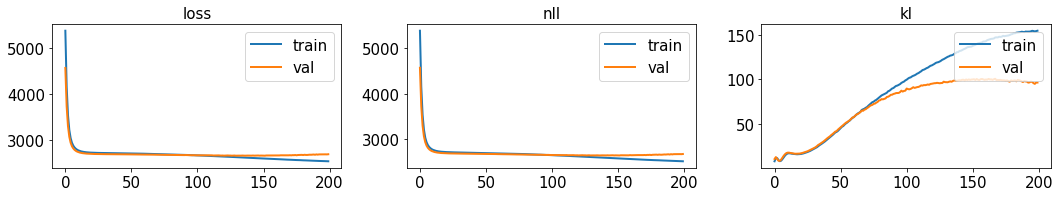

In [37]:
# diagnostics
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)
plt.tight_layout()
plt.show()

In [45]:
# torch.save(model.state_dict(), './pretrained/sim_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/sim_vae_pretrained.mod'))

In [39]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

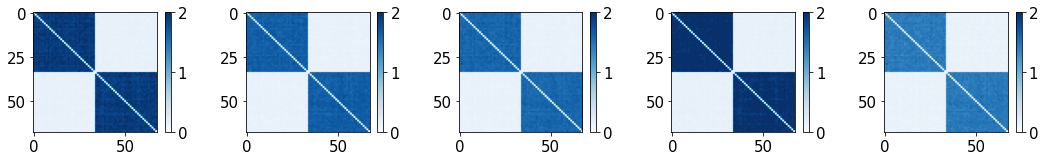

In [40]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 5, replace=False)]):
    p = axes[i].imshow(x, aspect='auto', cmap='Blues', vmin=0, vmax=2)
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [41]:
big_noise_recon = x_recon[np.arange(n_noisy_nets)]
small_noise_recon = x_recon[np.arange(n_noisy_nets, n_nets)]
diff_noise_recon= small_noise_recon.mean(0) - big_noise_recon.mean(0)

In [42]:
pca = PCA(2)
vae_Xt = pca.fit_transform(vae_latents)
vae_df = pd.DataFrame({"pc1": vae_Xt[:,0], "pc2": vae_Xt[:,1], "noise": noises})

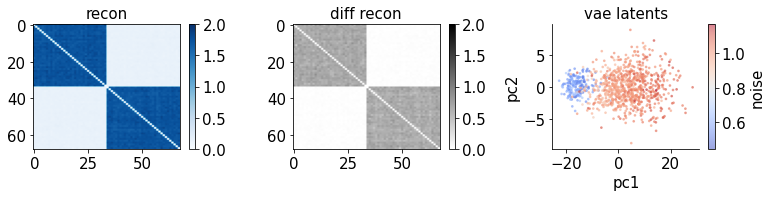

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))

p1 = axes[0].imshow(x_recon.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0].set_title('recon')
cbar = plt.colorbar(p1, ax=axes[0])

p2 = axes[1].imshow(diff_noise_recon, aspect='auto', cmap='binary', vmin=0, vmax=2)
axes[1].set_title('diff recon')
cbar = plt.colorbar(p2, ax=axes[1])

p3 = axes[2].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=vae_df, s=3, alpha=0.5)
axes[2].set_xlabel('pc1')
axes[2].set_ylabel('pc2')
axes[2].set_title('vae latents')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[2], label="noise")

plt.tight_layout()
plt.show()

inv_vae

In [20]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=1,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = 1., gamma = .5, add_reg = False, y_dim = 0,               
    batch_size=32, n_epochs=200, lr=3e-6, device=DEVICE)

In [21]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [22]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.custom_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.custom_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 4131.147 nll: 5500.476 kl: 5.717 inv_loss: 0.145
epoch: 0 test loss 3524.682 nll: 4693.408 kl: 4.548 inv_loss: 0.156
epoch: 5 train loss: 2210.967 nll: 2945.618 kl: 1.711 inv_loss: 0.086
epoch: 5 test loss 2214.430 nll: 2950.365 kl: 1.608 inv_loss: 0.096
epoch: 10 train loss: 2081.683 nll: 2773.997 kl: 1.155 inv_loss: 0.060
epoch: 10 test loss 2102.886 nll: 2802.320 kl: 1.111 inv_loss: 0.070
epoch: 15 train loss: 2053.493 nll: 2736.875 kl: 0.815 inv_loss: 0.043
epoch: 15 test loss 2074.994 nll: 2765.544 kl: 0.810 inv_loss: 0.052
epoch: 20 train loss: 2044.190 nll: 2724.754 kl: 0.609 inv_loss: 0.033
epoch: 20 test loss 2065.187 nll: 2752.733 kl: 0.617 inv_loss: 0.040
epoch: 25 train loss: 2040.522 nll: 2720.053 kl: 0.470 inv_loss: 0.025
epoch: 25 test loss 2060.945 nll: 2747.259 kl: 0.486 inv_loss: 0.031
epoch: 30 train loss: 2038.798 nll: 2717.896 kl: 0.366 inv_loss: 0.019
epoch: 30 test loss 2059.033 nll: 2744.847 kl: 0.385 inv_loss: 0.024
epoch: 35 train loss: 20

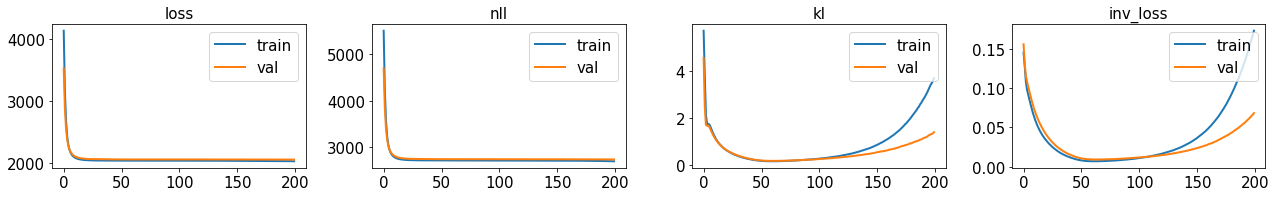

In [23]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [31]:
# torch.save(inv_model.state_dict(), './pretrained/sim_inv_vae_pretrained.mod')
# inv_model.load_state_dict(torch.load('./pretrained/sim_inv_vae_pretrained.mod'))

In [25]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()
x_denoised = inv_model.decode(z_sample, 
                      torch.ones_like(tensor_noises).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

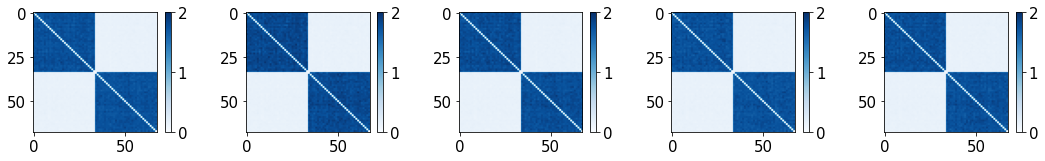

In [26]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2.5))
for i, x in enumerate(x_denoised[np.random.choice(ids, 5, replace=False)]):
    p = axes[i].imshow(x, aspect='auto', cmap='Blues', vmin=0, vmax=2)
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [27]:
big_noise_denoised = x_denoised[np.arange(n_noisy_nets)]
small_noise_denoised = x_denoised[np.arange(n_noisy_nets, n_nets)]
diff_noise_denoised = small_noise_denoised.mean(0) - big_noise_denoised.mean(0)

In [28]:
pca = PCA(2)
inv_vae_Xt = pca.fit_transform(inv_latents)
inv_vae_df = pd.DataFrame({"pc1": inv_vae_Xt[:,0], "pc2": inv_vae_Xt[:,1], "noise": noises})

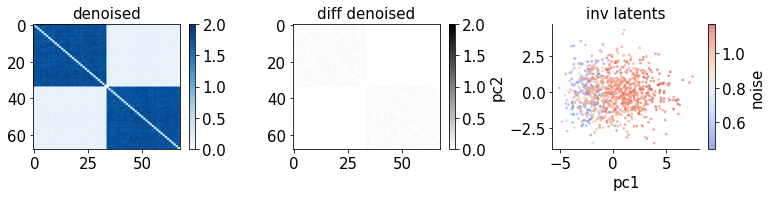

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))

p1 = axes[0].imshow(x_denoised.mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=2)
axes[0].set_title('denoised')
cbar = plt.colorbar(p1, ax=axes[0])

p2 = axes[1].imshow(diff_noise_denoised, aspect='auto', cmap='binary', vmin=0, vmax=2)
axes[1].set_title('diff denoised')
cbar = plt.colorbar(p2, ax=axes[1])

p3 = axes[2].scatter(x="pc1", y="pc2", c="noise", cmap='coolwarm', data=inv_vae_df, s=3, alpha=0.5)
axes[2].set_xlabel('pc1')
axes[2].set_ylabel('pc2')
axes[2].set_title('inv latents')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
cbar = plt.colorbar(p3, ax=axes[2], label="noise")

plt.tight_layout()
plt.show()